In [ ]:
!python --version

Python 3.6.9


In [ ]:
import numpy as np
import tensorflow as tf
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [ ]:

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std= (0.5)),
    transforms.Lambda(lambda x: torch.flatten(x))
])

In [ ]:
EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.001


train_dataset = FashionMNIST('./data',
                      train = True,
                      transform = img_transform,
                      download = True)

train_dataloader = DataLoader(train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = 2)

test_dataset = FashionMNIST('./data',
                      train = False,
                      transform = img_transform,
                      download = True)

test_dataloader = DataLoader(test_dataset,
                              batch_size = BATCH_SIZE//2,
                              shuffle = True)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


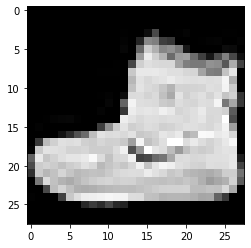

In [ ]:
type(train_dataloader)
import numpy as np

img = train_dataloader.dataset[0][0]

img_np = np.array(img).reshape(28,28)

plt.imshow(img_np,cmap='gray')

In [ ]:
class autoencoder(nn.Module):
  
  def __init__(self):

    super(autoencoder,self).__init__()

    self.encoder = nn.Sequential(
      nn.Linear(28*28,100),
      nn.ReLU(),
      nn.Linear(100,100),
      nn.ReLU()
    )

    
    self.decoder = nn.Sequential(
      nn.Linear(100,100),
      nn.ReLU(),
      nn.Linear(100,28*28),
      nn.ReLU()
    )

  def forward(self,x):

    x = self.encoder(x)

    x = self.decoder(x)

    return x

  def get_encodings(self, x):

    encoded = self.encoder(x)

    return encoded

In [ ]:
model = autoencoder().cuda()
cost = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = LEARNING_RATE,weight_decay=1e-5)

In [ ]:
def to_img(x):
    x = (0.5 * x) + 0.5
    return (x.view(x.shape[0],1,28,28))

In [ ]:
def train_model(model,dataloader,epochs,cost,optimizer):

  loss_values = []

  for epoch in range(epochs):

    for data in dataloader:

      img,_ = data

      #convert to cuda for GPU
      img = Variable(img).cuda()

      #predict the output
      output = model(img)

      #compute the loss
      loss = cost(output,img)

      #initialize the weights to zero
      optimizer.zero_grad()

      #computes the gradients
      loss.backward()

      #updates the paramters
      optimizer.step()

    print('epoch [{}/{}], loss:{:.4f}'.format(epoch,epochs,loss.data))
    
    loss_values.append(loss.data)

  return loss_values

In [ ]:
loss_history = train_model(model,train_dataloader,EPOCHS,cost,optimizer)

epoch [0/20], loss:0.6169
epoch [1/20], loss:0.5881
epoch [2/20], loss:0.5973
epoch [3/20], loss:0.5885
epoch [4/20], loss:0.5995
epoch [5/20], loss:0.5793
epoch [6/20], loss:0.6084
epoch [7/20], loss:0.5983
epoch [8/20], loss:0.5818
epoch [9/20], loss:0.6032
epoch [10/20], loss:0.5937
epoch [11/20], loss:0.6259
epoch [12/20], loss:0.6014
epoch [13/20], loss:0.5915
epoch [14/20], loss:0.6044
epoch [15/20], loss:0.5859
epoch [16/20], loss:0.6095
epoch [17/20], loss:0.6015
epoch [18/20], loss:0.6119
epoch [19/20], loss:0.5940


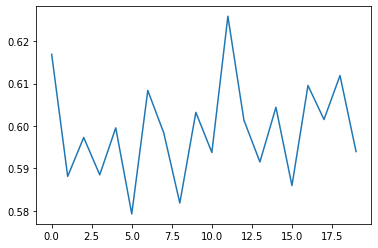

In [ ]:
history = np.asarray(loss_history)
plt.plot(history)
plt.show()

The input set of images



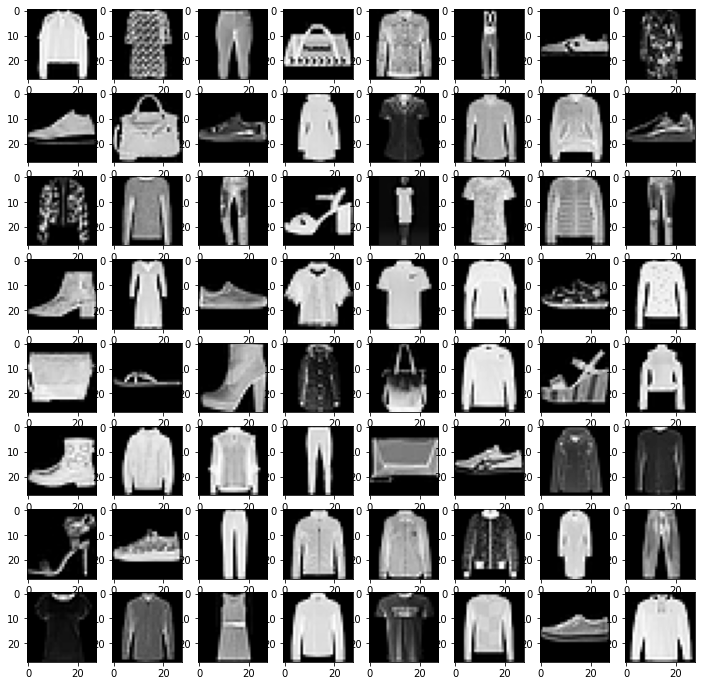

Achieved outputs



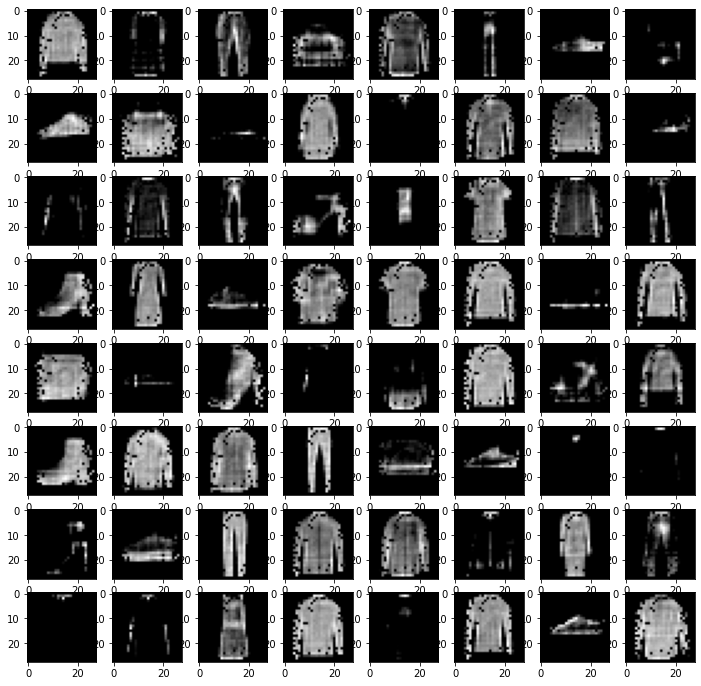

In [ ]:
imgs,_ = next(iter(test_dataloader))
fig = plt.figure(figsize=(12,12))
x = imgs[:64]

print("The input set of images\n")

for i,image in enumerate(x):

    plt.subplot(8,8,i+1)
    image = (np.asarray(image).reshape(28,28) * 0.5) + 0.5  # unflattening and rescaling
    plt.imshow(image, cmap = 'gray')

plt.show()

print("Achieved outputs\n")

fig = plt.figure(figsize=(12,12))
x = Variable(imgs[:64]).cuda()
x = model(x).cpu().detach().numpy()
for i,image in enumerate(x):
    plt.subplot(8,8,i+1)
    image = (np.asarray(image).reshape(28,28) * 0.5) + 0.5  # unflattening and rescaling
    plt.imshow(image, cmap = 'gray')

plt.show()

In [ ]:

imgs,_ = next(iter(test_dataloader))
imgs = imgs[:8].cuda()

encoded = model.get_encodings(imgs)
output = model(imgs)
print(encoded.shape,output.shape)

torch.Size([8, 100]) torch.Size([8, 784])
